In [1]:
!pip install tensorflow
!pip install pandas
!pip install seaborn


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [9]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [10]:
# Parameters
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNEL = 3
EPOCHS = 10

In [11]:
# Loading Dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Cotton",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 6628 files belonging to 8 classes.


In [12]:
# Getting class names
class_names = dataset.class_names
n_classes = len(class_names)  # Automatically detect number of classes

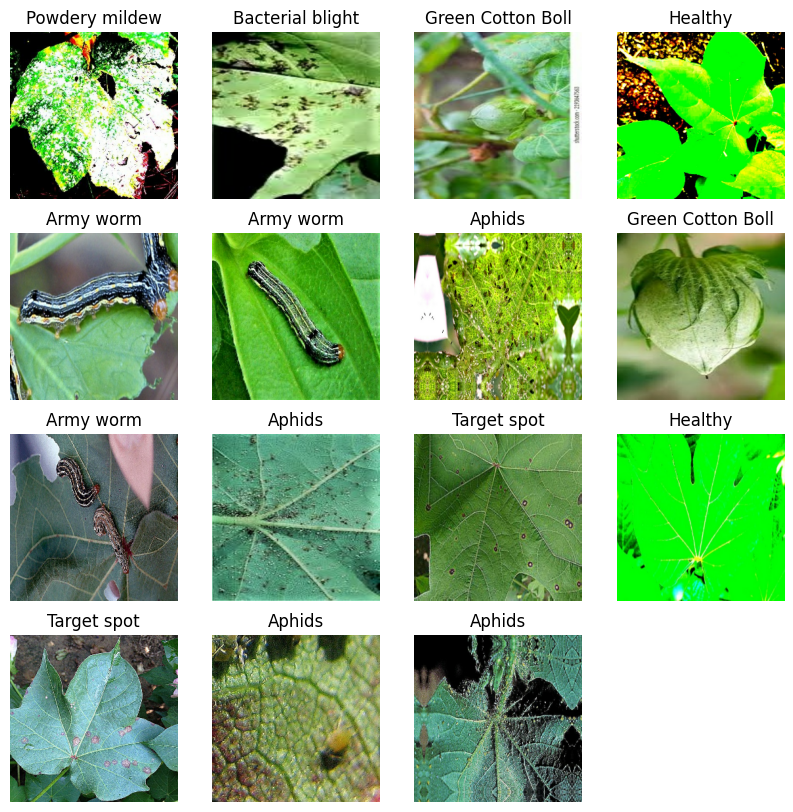

In [13]:
# Visualizing the dataset
plt.figure(figsize=(10, 10))
for images_batch, labels_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
   

In [ ]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [ ]:
# Splitting Dataset into Trainning, Validation, and Testing
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# Optimizing dataset loading
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Data Preprocessing and Augmentation
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),

])

In [ ]:
# Building the CNN Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNEL)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),  
    resize_and_rescale,  
    data_augmentation,
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),  # To avoid overfitting

    tf.keras.layers.Dense(n_classes, activation='softmax'),
])


model.summary()



In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Update the loss function
    metrics=['accuracy']
)


In [ ]:
# Trainning the Model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)


In [ ]:
# Evaluating the Model on Test Data
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {scores[1]*100:.2f}%")

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
# Plotting Accuracy and Loss over Epochs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()


In [ ]:
# Prediction Function
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

In [ ]:
# Display Predictions
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\nConfidence: {confidence}%")
        plt.axis("off")

plt.show()


In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:

# Prediction function for test dataset
def get_predictions(model, dataset):
    all_preds = []
    all_labels = []
    
    for images, labels in dataset:
        # Predict the classes for the batch of images
        predictions = model.predict(images)
        predicted_classes = np.argmax(predictions, axis=1)
        
        # Store predictions and true labels
        all_preds.extend(predicted_classes)
        all_labels.extend(labels.numpy())
    
    return np.array(all_labels), np.array(all_preds)

In [ ]:
# Evaluate model and plot confusion matrix
y_true, y_pred = get_predictions(model, test_ds)

# Display the confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)

In [ ]:
model_version = 1
model.save(f"../saved_models/{model_version}.keras")